## エリアによってamountの絶対値あたりの価値は違うという仮説で、特徴をMain Stateあたりのリフトにする

In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features
import datetime

from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
from sklearn.metrics import mean_squared_error

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

### Data Load

In [2]:
hist = utils.read_df_pkl('../input/hist_clean*0*')
new = utils.read_df_pkl('../input/new_clean*0*')
df = pd.concat([hist, new], axis=0)

100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


### City_id

In [3]:
#========================================================================
# State_id
#========================================================================

df['cnt'] = 1
df_state = df.groupby([key, 'state_id'])['cnt'].sum().reset_index()
df_rec = df.groupby([key])['cnt'].sum().reset_index()

main = df_state.merge(df_rec, how='inner', on=key)
del df_state, df_rec
gc.collect()

df['authorized_flag'] = df['authorized_flag'].map(lambda x: 0 if x=='N' else 1)
auth_mean = df.groupby('state_id')['authorized_flag'].mean()

main['main_state_ratio'] = main['cnt_x'] / (main['cnt_y'])
main_state_idx = main.groupby(key)['main_state_ratio'].idxmax()

main_state = main.iloc[main_state_idx][[key, 'state_id', 'main_state_ratio']]
main_state['main_state_auth_mean'] = main_state['state_id'].map(auth_mean)
print(main_state.shape)
main_state.head()
main_state.rename(columns={'state_id':'main_state_id'}, inplace=True)

,card_id,state_id,cnt_x,cnt_y
0,C_ID_00007093c1,-1,28,151
1,C_ID_00007093c1,2,121,151
2,C_ID_00007093c1,9,1,151
3,C_ID_00007093c1,21,1,151
4,C_ID_0001238066,-1,11,149
5,C_ID_0001238066,5,1,149
6,C_ID_0001238066,9,112,149
7,C_ID_0001238066,15,3,149
8,C_ID_0001238066,20,21,149
9,C_ID_0001238066,21,1,149


(325540, 4)


,card_id,state_id,main_state_ratio,main_state_auth_mean
1,C_ID_00007093c1,2,0.801325,1
6,C_ID_0001238066,9,0.751678,1
11,C_ID_0001506ef0,19,0.970588,1
12,C_ID_0001793786,-1,0.469636,1
18,C_ID_000183fdda,3,0.890323,1


In [10]:
main_state.set_index(key, inplace=True)

df_train = utils.read_df_pkl('../input/train0*')
df_test = utils.read_df_pkl('../input/test0*')
df_train.set_index(key, inplace=True)
df_test.set_index(key, inplace=True)
train_test = pd.concat([df_train, df_test], axis=0)

train_test = train_test.join(main_state['main_state_id'])
# state -1 (net?)の割合
net_ratio = main[main['state_id']==-1][[key, 'main_state_ratio']]
train_test['state-1_ratio'] = net_ratio.set_index(key)
train_test.head()

100%|██████████| 3/3 [00:00<00:00, 136.64it/s]


,feature_1,feature_2,feature_3,first_active_month,target,main_state_id
card_id,,,,,,
C_ID_92a2005557,5,2,1,2017-06,-0.820283,9
C_ID_3d0044924f,4,1,0,2017-01,0.392913,9
C_ID_d639edf6cd,2,2,0,2016-08,0.688056,5
C_ID_186d6a6901,4,3,0,2017-09,0.142495,22
C_ID_cdbd2c0db2,1,3,0,2017-11,-0.159749,22


### main_state_id別にtargetの分布を見ると, -1, 11, 24, 15などは特徴がある

9: 64191


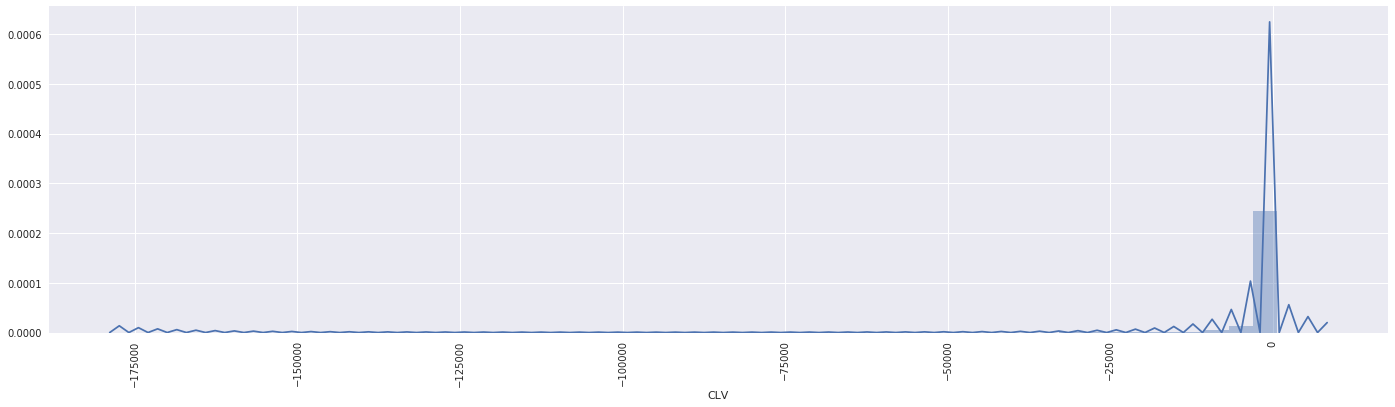

-1: 17887


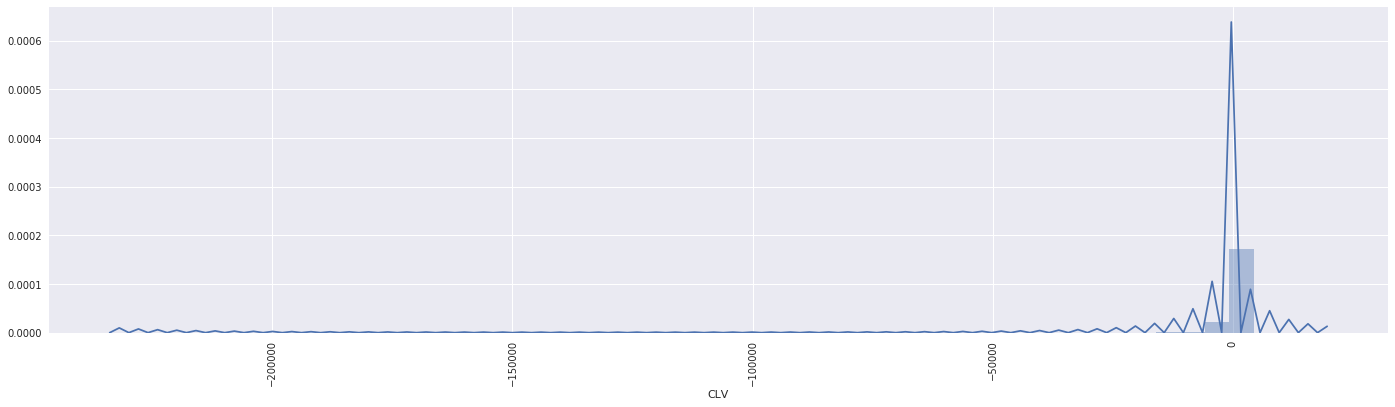

16: 16414


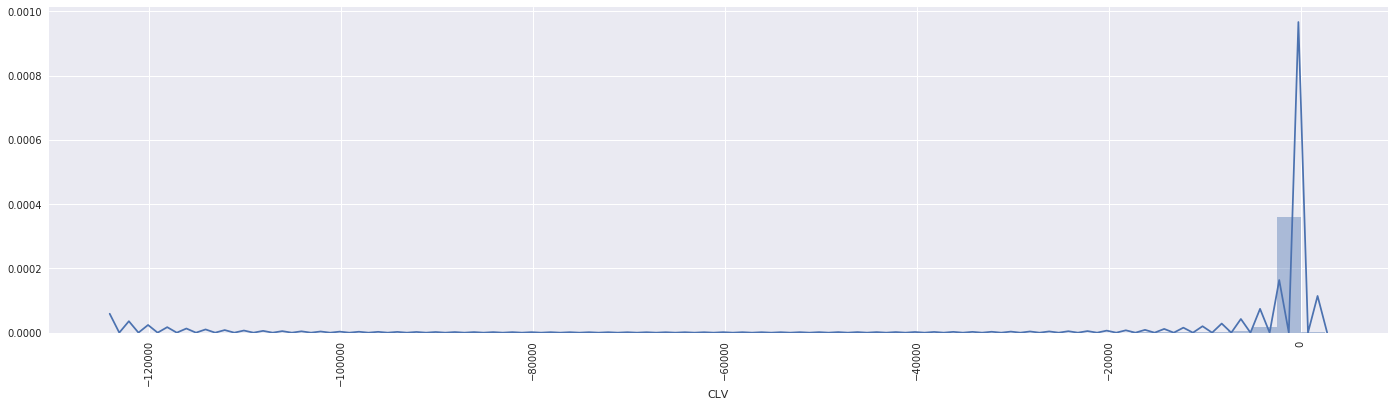

15: 16097


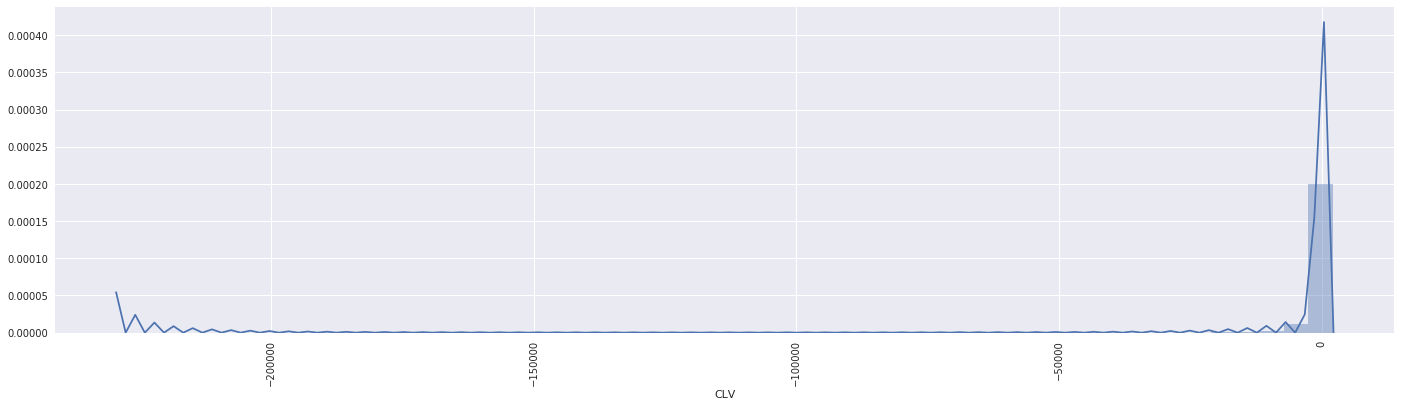

5: 11038


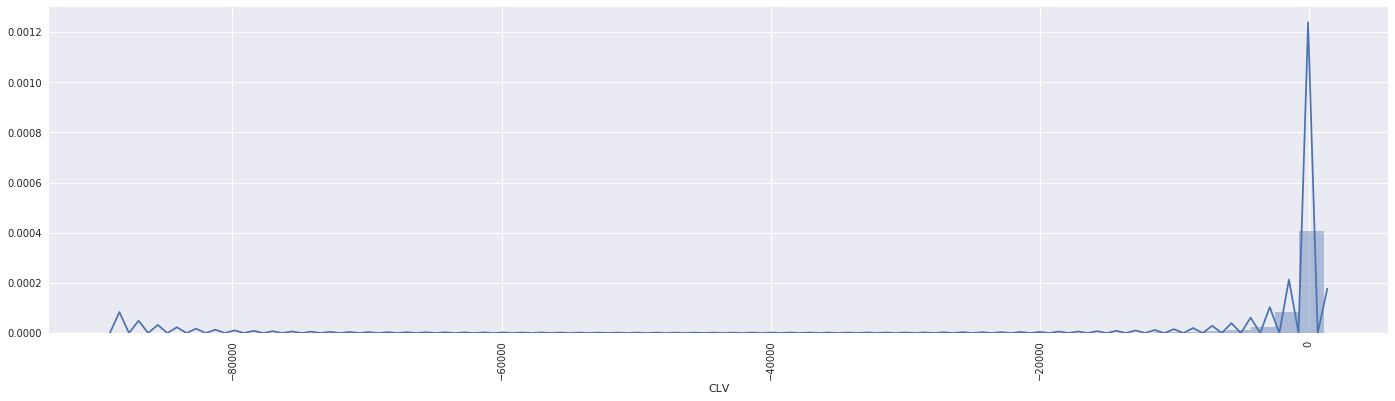

19: 10045


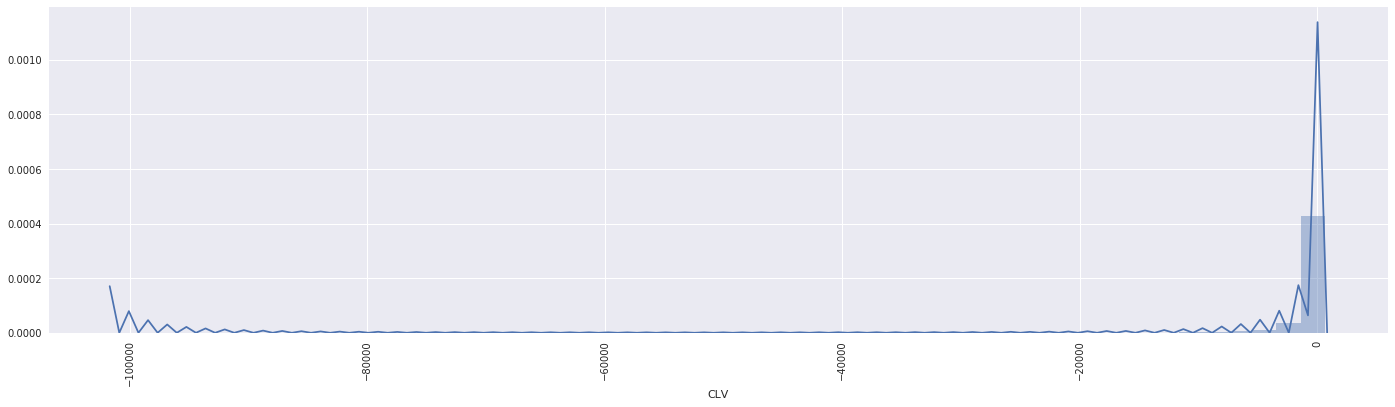

20: 7694


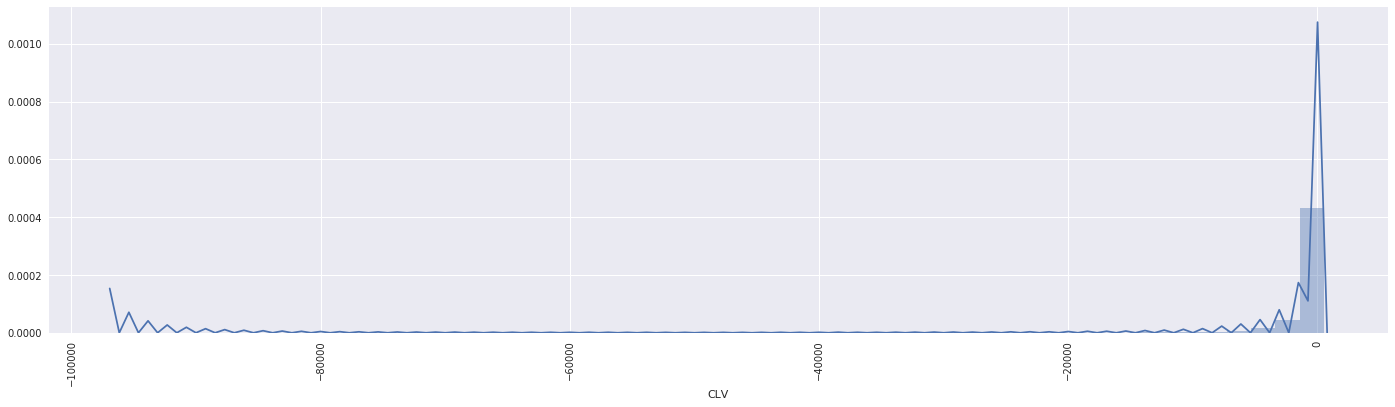

21: 7288


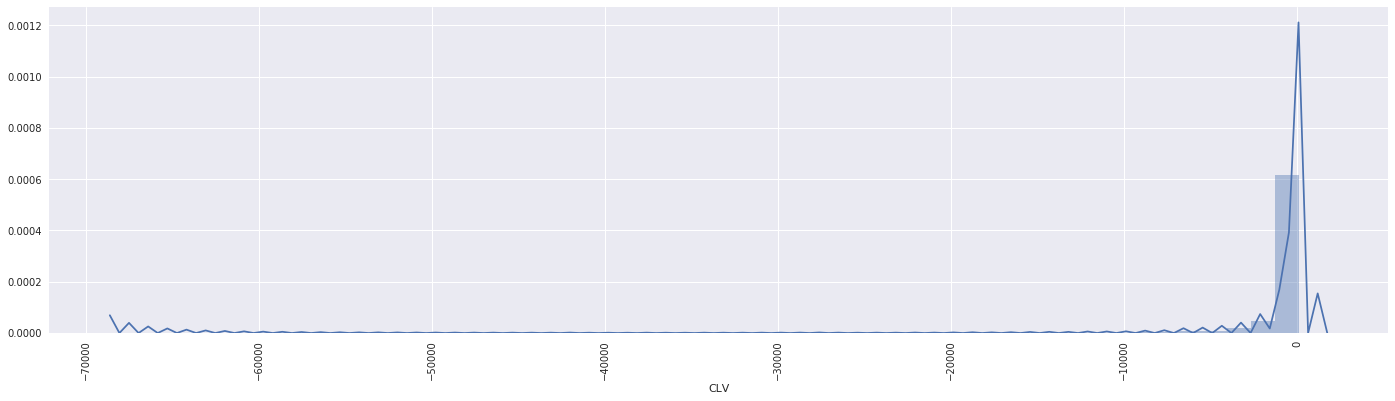

4: 6439


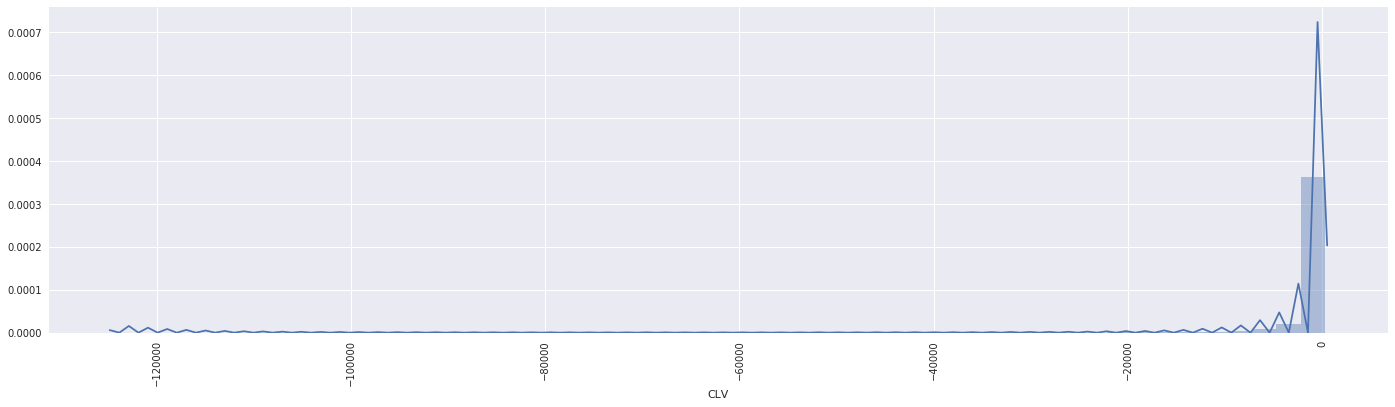

22: 5461


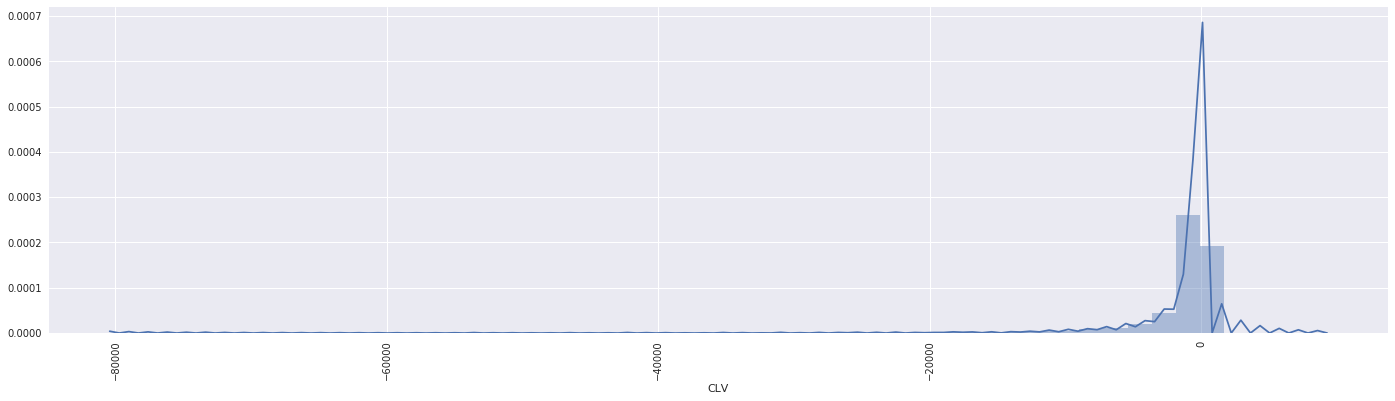

11: 5441


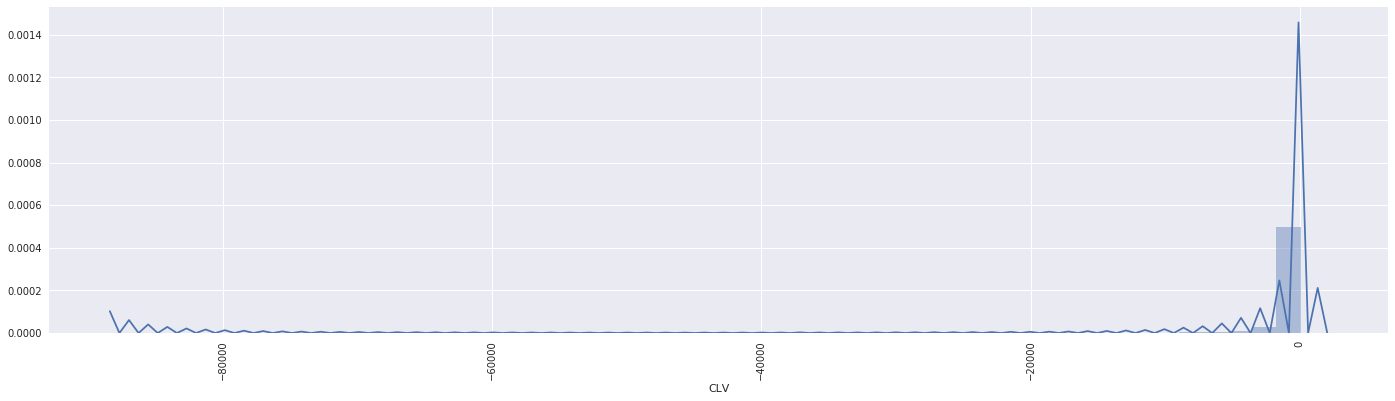

7: 5406


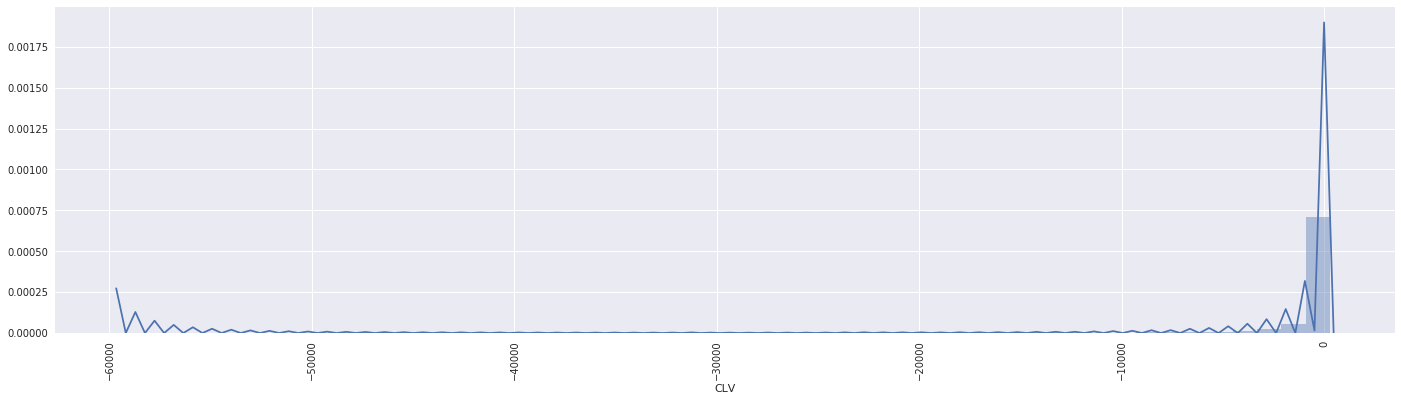

3: 4449


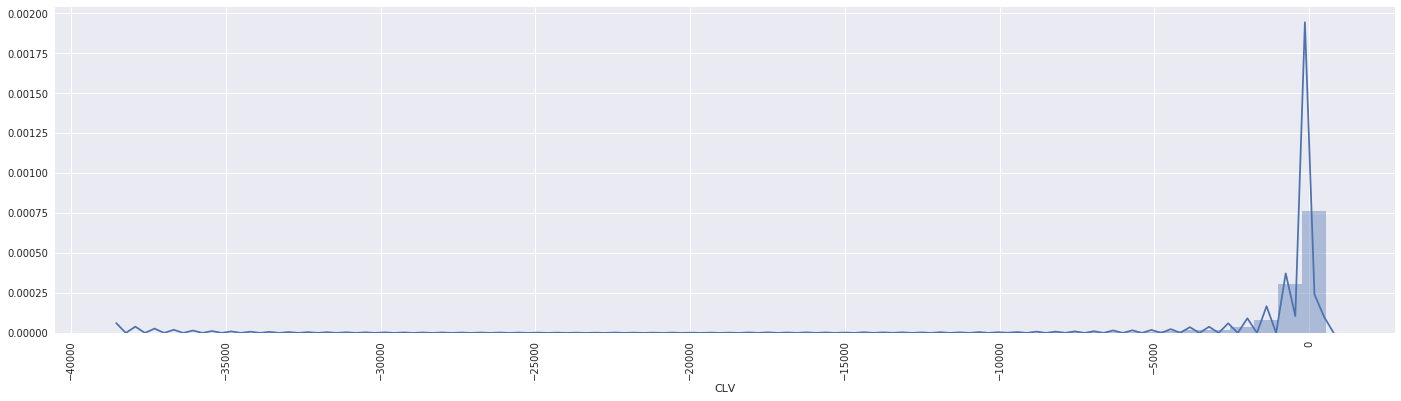

13: 4206


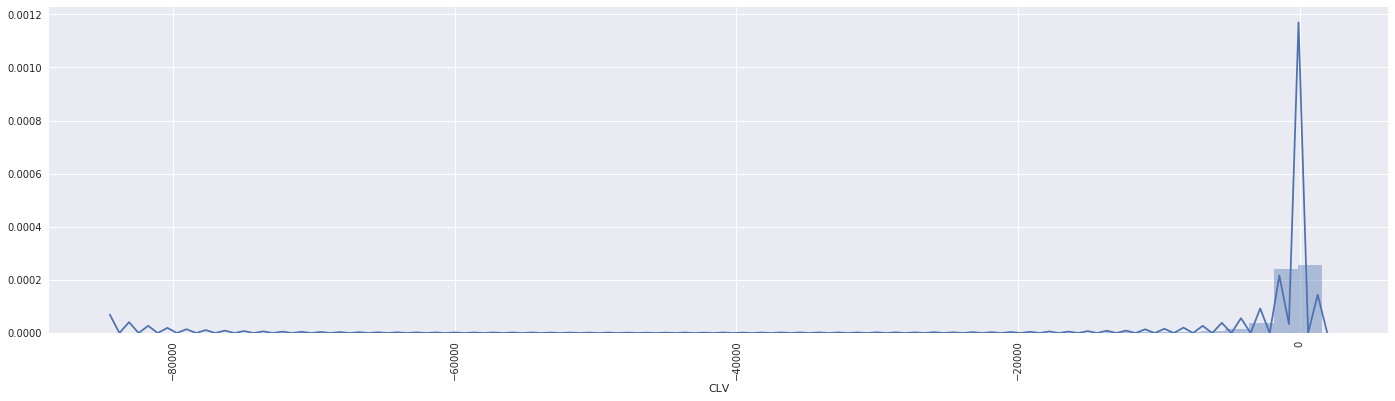

2: 2931


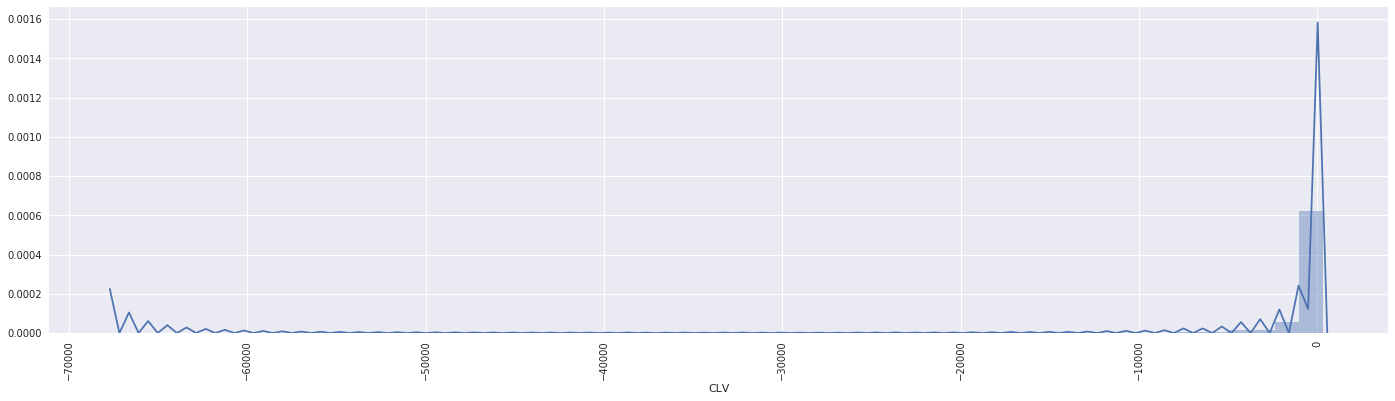

12: 2957


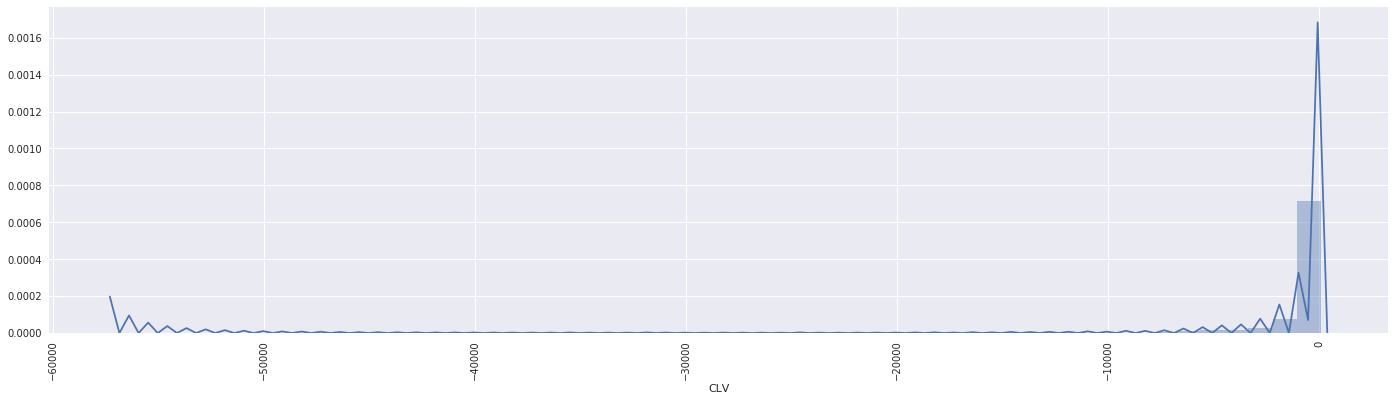

18: 2513


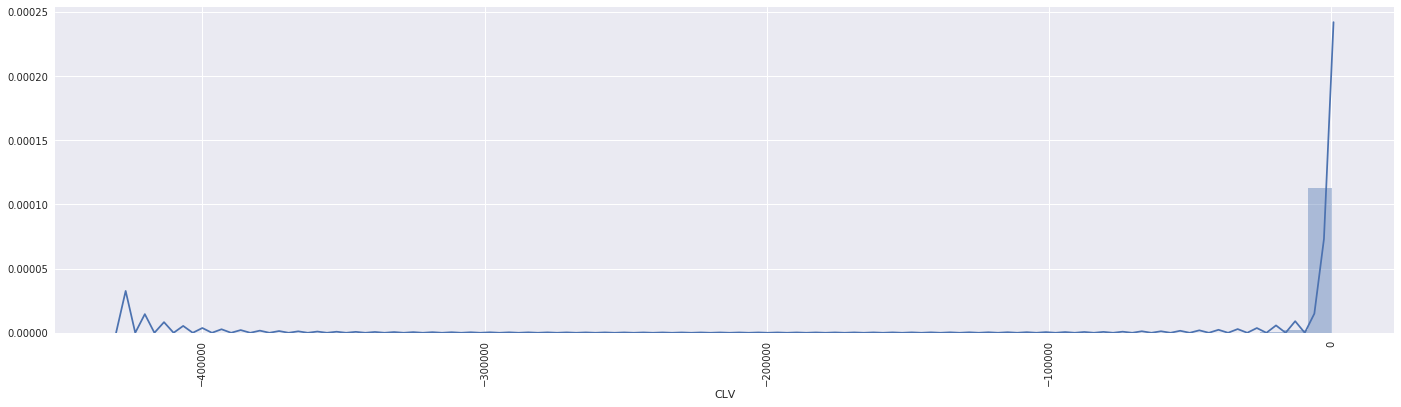

1: 2073


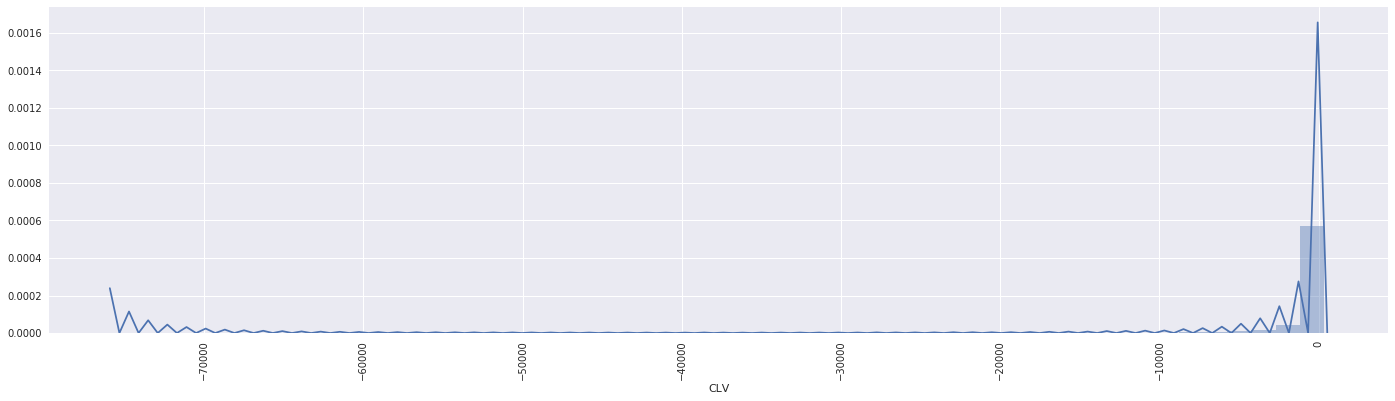

10: 1882


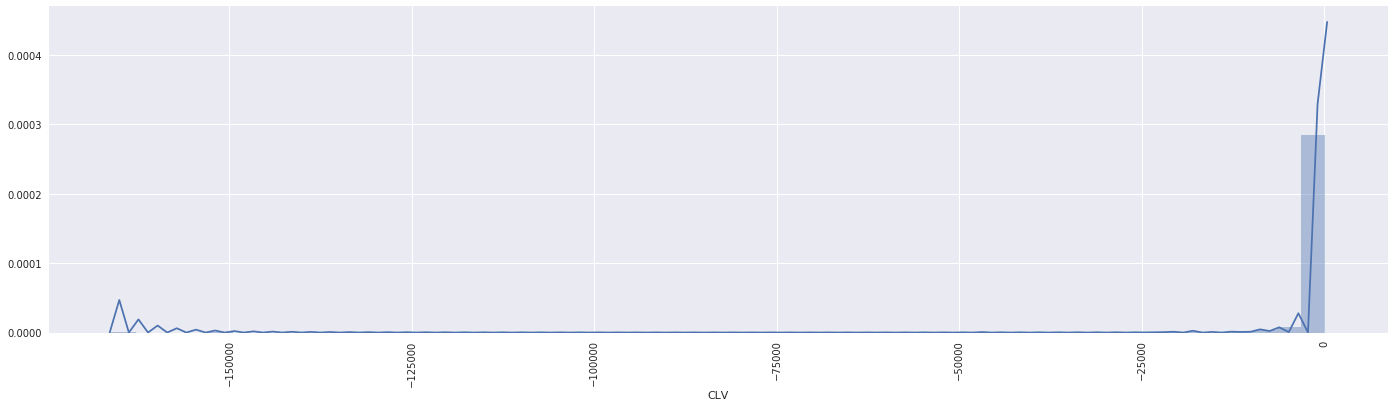

24: 1883


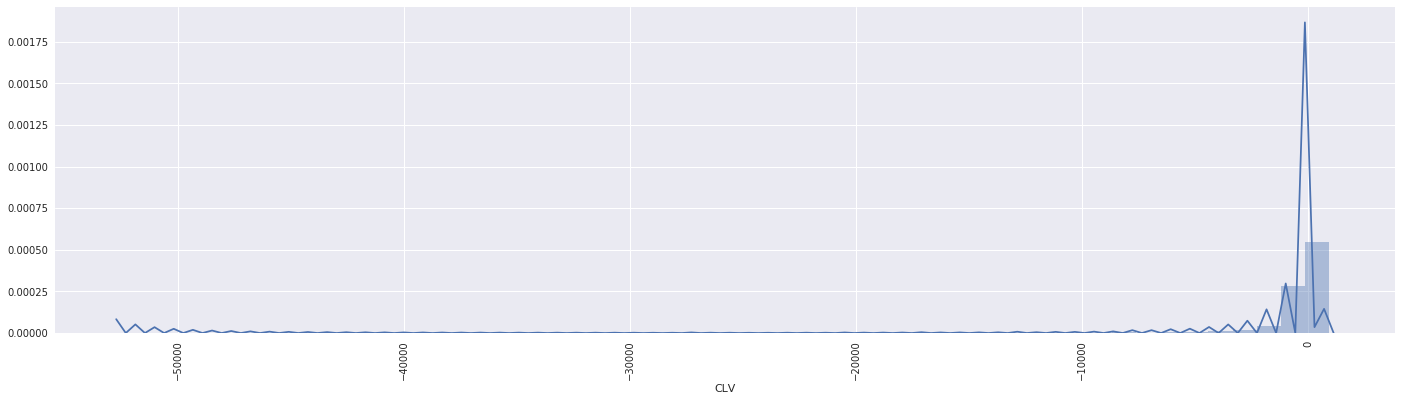

8: 1583


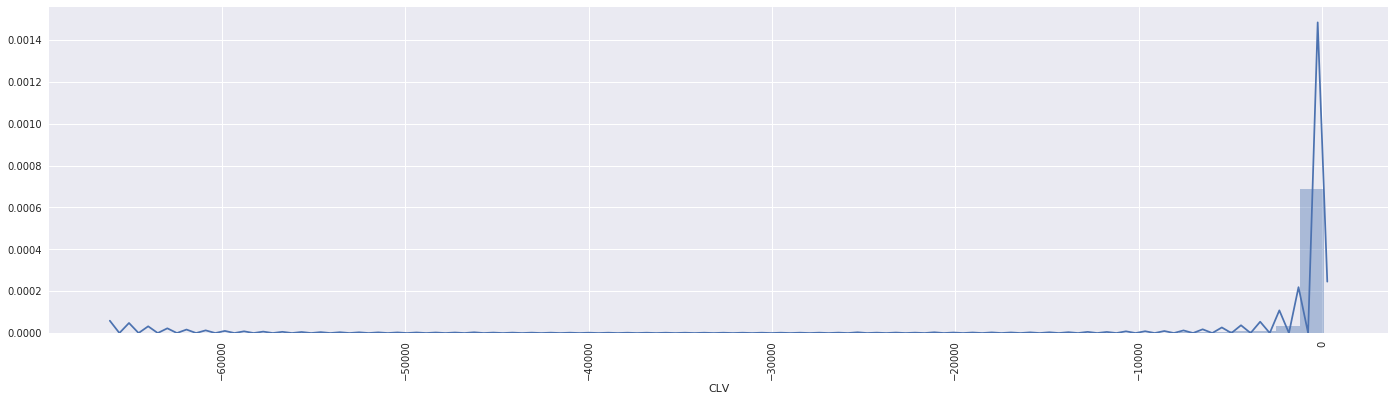

23: 1489


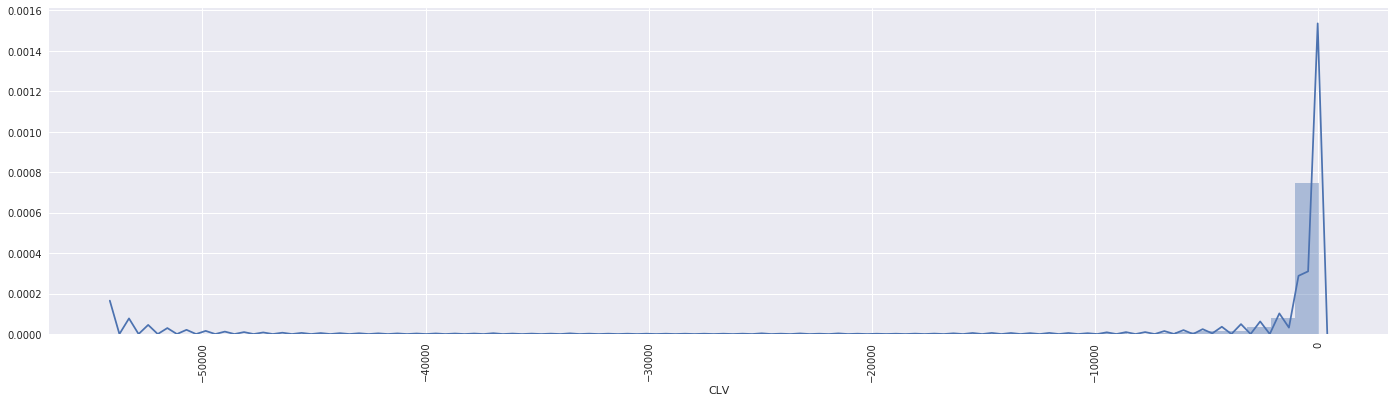

14: 1427


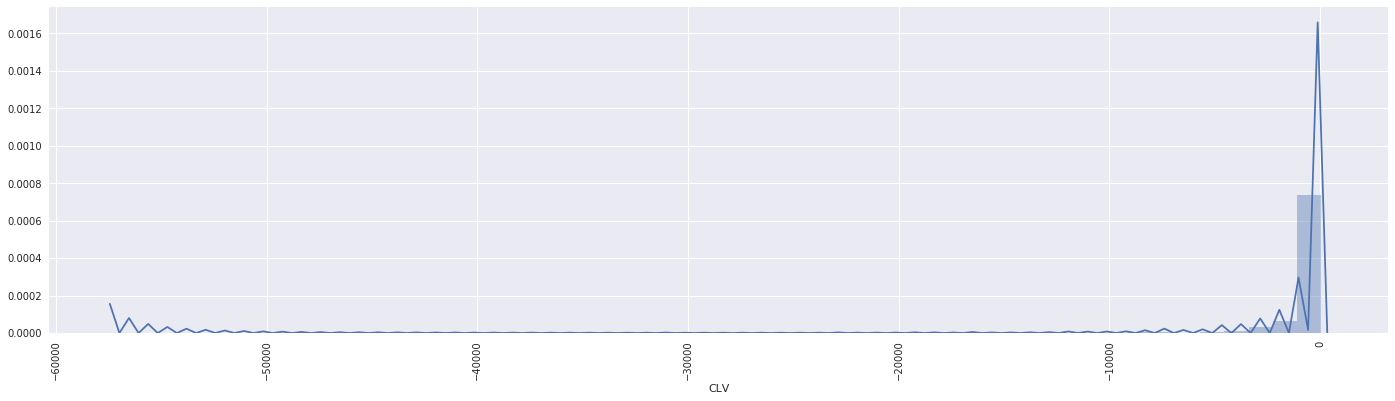

17: 1054


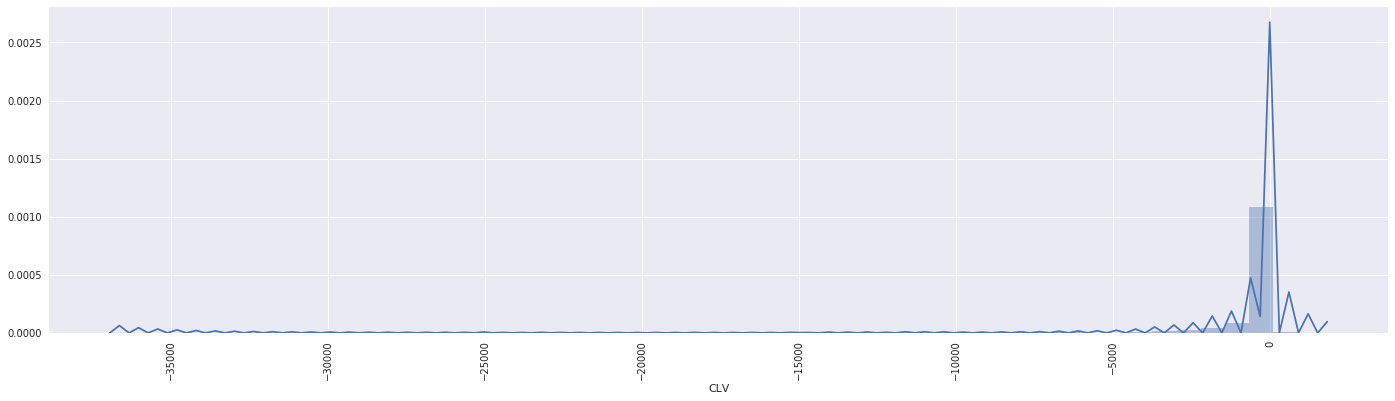

6: 69


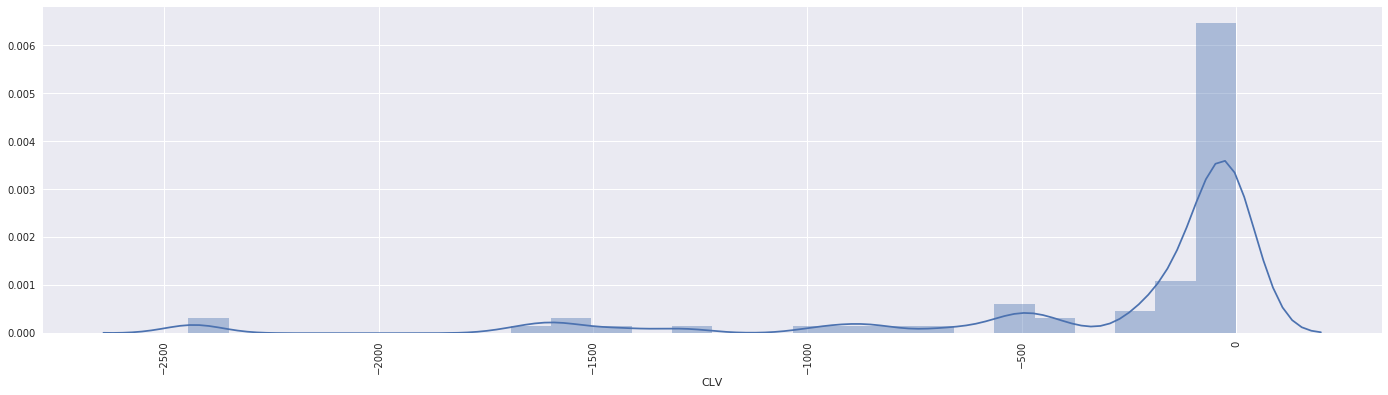

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

viz_col = 'CLV'

main_state_list = list(main_state['main_state_id'].value_counts().index)
train_test[viz_col] = utils.read_pkl_gzip('../features/4_winner/200_ker_hist_CLV@.gz')
df_train = train_test[~train_test[target].isnull()]
df = df_train

for i in main_state_list:
    tmp = df[df['main_state_id']==i]
    
    print(f"{i}: {len(tmp)}")
    
#========================================================================
    # Main StateにおけるOutlierの割合をとる
#     tmp[target] = tmp[target].map(lambda x: np.round(x, 1))
#     tmp = tmp[target].value_counts().reset_index()
#     max_target = tmp[target].max()
#     tmp[target] /= max_target
#     out_ratio = tmp[tmp['index']<-30][target].values[0]
#     train_test.loc[train_test['main_state_id']==i, 'out_ratio'] = out_ratio
#========================================================================
#     plt.figure(figsize=(24, 6))
#     sns.distplot(a=tmp[viz_col])
#     sns.barplot(data=tmp, x='index', y=target)
#     plt.xticks(rotation=90)
#     plt.show()

In [53]:
#========================================================================
# Main State Ratio, Main State Out Ratio
prefix = '216_mst'
# for col in ['out_ratio', 'main_state_id']:
for col in ['state-1_ratio']:
    feature = train_test[col].values.astype('float32')
    if col=='out_ratio':
        col = 'state_' + col
    utils.to_pkl_gzip(obj=feature, path=f'../features/1_first_valid/{prefix}_{col}')
#========================================================================